In [1]:
import chainer
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

import os
import time, datetime
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import coordinate
import data
from model import oplus, Generator
import xp_settings as settings
settings.set_gpu(0)
xp = settings.xp


In [2]:
def plot_path(cart_path,target):
    fig = plt.figure()
    path = cart_path
    target = target
    if(settings.gpu_index >= 0):
        path = xp.asnumpy(path)
        target = xp.asnumpy(target)
    plt.scatter(target[:,0],target[:,1],c="red",s=80,marker="o")
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color="blue")
    num_step = len(target)
    #plt.scatter(t[num_step-1,0],t[num_step-1,1],c="yellow",s=500,marker="*")
    plt.xlabel("x[m]")
    plt.ylabel("y[m]")
    plt.axis('scaled')
    plt.grid()
    plt.show()
    return fig

In [3]:
print('Sample 1 : check Oplus')
sample_x1 = Variable(xp.array([1, 1, 1], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 2, 0], dtype = 'float32'))
print(sample_x1.shape)
sample_z = oplus(sample_x1,sample_x2)
print(sample_z)
sample_z = sample_z * xp.array([1., 1., 0], dtype='float32')
sample_zt = F.transpose(sample_z)
print(sample_zt)
sample_e = F.matmul(sample_z, sample_zt)
print(sample_e)
print(sample_e.shape)
sample_e.backward()

Sample 1 : check Oplus
(3,)
variable([-0.14263964  2.9220755   1.0000002 ])
variable([-0.14263964  2.9220755   0.        ])
variable(8.558871)
()


Sample 2 : plot Oplus
variable([1.8660254 0.5       1.0471976])
variable([2.3660254 1.3660254 1.5707963])
variable([2.3660254 2.3660254 2.094395 ])
[[1.        0.        0.5235988]
 [1.8660254 0.5       1.0471976]
 [2.3660254 1.3660254 1.5707963]
 [2.3660254 2.3660254 2.094395 ]]


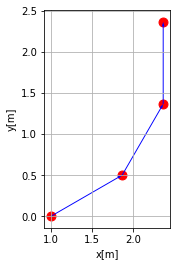

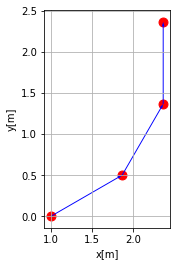

In [4]:
print('Sample 2 : plot Oplus')
sample_x1 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x2 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x3 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_x4 = Variable(xp.array([1, 0, xp.pi/6], dtype = 'float32'))
sample_z1 = oplus(sample_x1,sample_x2)
print(sample_z1)
sample_z2 = oplus(sample_z1,sample_x3)
print(sample_z2)
sample_z3 = oplus(sample_z2,sample_x4)
print(sample_z3)
sample_z = sample_z3 * xp.array([1., 1., 0], dtype='float32')
sample_pathes = xp.array(xp.vstack((sample_x1.data,sample_z1.data,sample_z2.data,sample_z3.data)),dtype='float32')
print(sample_pathes)
plot_path(sample_pathes,sample_pathes)

In [5]:
# dataset
DATA_SIZE = 1000
DATA_NUM_WAYPOINTS = 10
DATA_NUM_STEP = DATA_NUM_WAYPOINTS
DATA_HZ = 10
DATA_V_STEP = 0.5 / DATA_HZ # [m/step]
DATA_MAX_V_STEP = 1.0 / DATA_HZ # [m/step]
DATA_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_MAX_W_STEP = xp.pi * 0.5 / DATA_HZ # [rad/step]
DATA_NUM_PREVIOUS_U = 0
DATA_RANGE_TRANSLATE = 0 # 経路を直進方向にずらす
DATA_RANGE_ROTATE = 0 # 経路を回転方向にずらす

params = []
params.append('DATA_SIZE            :'+str(DATA_SIZE))
params.append('DATA_NUM_WAYPOINTS   :'+str(DATA_NUM_WAYPOINTS))
params.append('DATA_NUM_STEP        :'+str(DATA_NUM_STEP))
params.append('DATA_V_STEP          :'+str(DATA_V_STEP))
params.append('DATA_MAX_V_STEP      :'+str(DATA_MAX_V_STEP))
params.append('DATA_W_STEP          :'+str(DATA_W_STEP))
params.append('DATA_MAX_W_STEP      :'+str(DATA_MAX_W_STEP))
params.append('DATA_NUM_PREVIOUS_U  :'+str(DATA_NUM_PREVIOUS_U))
params.append('DATA_RANGE_TRANSLATE :'+str(DATA_RANGE_TRANSLATE))
params.append('DATA_RANGE_ROTATE    :'+str(DATA_RANGE_ROTATE))
for a in params:
    print(a)

DATA_SIZE            :1000
DATA_NUM_WAYPOINTS   :10
DATA_NUM_STEP        :10
DATA_V_STEP          :0.05
DATA_MAX_V_STEP      :0.1
DATA_W_STEP          :0.15707963267948966
DATA_MAX_W_STEP      :0.15707963267948966
DATA_NUM_PREVIOUS_U  :0
DATA_RANGE_TRANSLATE :0
DATA_RANGE_ROTATE    :0


In [6]:
X_train = []

for i in range(DATA_SIZE):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    X_train.append(d)
'''
# old version
for i in range(DATA_SIZE):
    l = int(DATA_NUM_WAYPOINTS*DATA_M_PER_STEP)+1
    rand_rad = xp.random.rand()*(2*DATA_RAD_PER_STEP)-DATA_RAD_PER_STEP # -36 ~ 36 m/step
    d = data.make_arc_path_2(l,rand_rad,s=DATA_M_PER_STEP)
    d_es,_ = data.old_get_evenly_spaced_points(d,DATA_M_PER_STEP)
    d_xy = d_es[0:DATA_NUM_WAYPOINTS]
    X_train.append(d_xy)
'''
print(len(X_train))
print(X_train[0].shape)

1000
(10, 3)


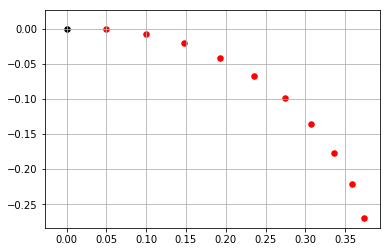

 -- x_train -- 
[[ 4.99599600e-02  1.86702233e-07 -1.77877506e+00]
 [ 9.94405039e-02 -6.90440442e-03 -1.91742506e+00]
 [ 1.47491949e-01 -2.05812532e-02 -2.05607506e+00]
 [ 1.93192043e-01 -4.07678594e-02 -2.19472506e+00]
 [ 2.35663660e-01 -6.70767804e-02 -2.33337506e+00]
 [ 2.74091642e-01 -9.90030678e-02 -2.47202506e+00]
 [ 3.07738437e-01 -1.35933959e-01 -2.61067506e+00]
 [ 3.35958263e-01 -1.77160638e-01 -2.74932506e+00]
 [ 3.58209494e-01 -2.21891839e-01 -2.88797506e+00]
 [ 3.74065061e-01 -2.69269034e-01 -3.02662506e+00]]


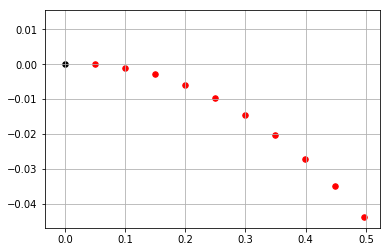

 -- x_train -- 
[[ 4.99992103e-02  5.75129539e-10 -1.60000134e+00]
 [ 9.99889439e-02 -9.73421970e-04 -1.61947134e+00]
 [ 1.49950252e-01 -2.91989864e-03 -1.63894134e+00]
 [ 1.99864194e-01 -5.83869159e-03 -1.65841134e+00]
 [ 2.49711851e-01 -9.72869439e-03 -1.67788134e+00]
 [ 2.99474327e-01 -1.45884325e-02 -1.69735134e+00]
 [ 3.49132757e-01 -2.04160636e-02 -1.71682134e+00]
 [ 3.98668319e-01 -2.72093788e-02 -1.73629134e+00]
 [ 4.48062235e-01 -3.49658029e-02 -1.75576134e+00]
 [ 4.97295781e-01 -4.36823957e-02 -1.77523134e+00]]


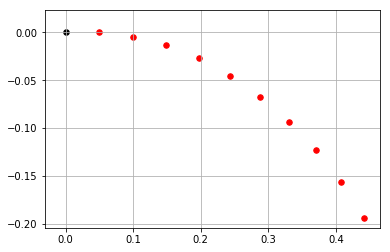

 -- x_train -- 
[[ 4.99825062e-02  6.38900326e-08 -1.70825761e+00]
 [ 9.97552914e-02 -4.57386111e-03 -1.79989761e+00]
 [ 1.48900661e-01 -1.36833905e-02 -1.89153761e+00]
 [ 1.97006188e-01 -2.72520771e-02 -1.98317761e+00]
 [ 2.43668168e-01 -4.51660522e-02 -2.07481761e+00]
 [ 2.88495015e-01 -6.72749815e-02 -2.16645761e+00]
 [ 3.31110540e-01 -9.33933266e-02 -2.25809761e+00]
 [ 3.71157114e-01 -1.23301902e-01 -2.34973761e+00]
 [ 4.08298664e-01 -1.56749714e-01 -2.44137761e+00]
 [ 4.42223499e-01 -1.93456069e-01 -2.53301761e+00]]


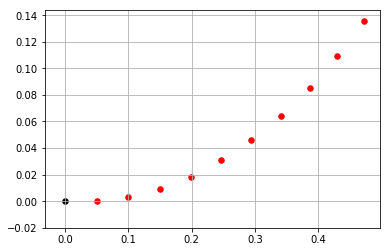

 -- x_train -- 
[[ 4.99919507e-02 -1.56483706e-07 -1.47755320e+00]
 [ 9.98873611e-02  3.10518621e-03 -1.41539320e+00]
 [ 1.49493504e-01  9.30403333e-03 -1.35323320e+00]
 [ 1.98618770e-01  1.85724411e-02 -1.29107320e+00]
 [ 2.47073406e-01  3.08746091e-02 -1.22891320e+00]
 [ 2.94670252e-01  4.61630187e-02 -1.16675320e+00]
 [ 3.41225457e-01  6.43786167e-02 -1.10459320e+00]
 [ 3.86559197e-01  8.54510429e-02 -1.04243320e+00]
 [ 4.30496364e-01  1.09298903e-01 -9.80273197e-01]
 [ 4.72867247e-01  1.35830081e-01 -9.18113197e-01]]


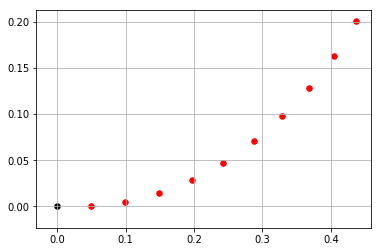

 -- x_train -- 
[[ 4.99807942e-02 -1.32740158e-07 -1.42676367e+00]
 [ 9.97313707e-02  4.79151982e-03 -1.33074367e+00]
 [ 1.48793389e-01  1.43308133e-02 -1.23472367e+00]
 [ 1.96714853e-01  2.85298646e-02 -1.13870367e+00]
 [ 2.43054274e-01  4.72578612e-02 -1.04268367e+00]
 [ 2.87384738e-01  7.03422665e-02 -9.46663671e-01]
 [ 3.29297839e-01  9.75704096e-02 -8.50643671e-01]
 [ 3.68407441e-01  1.28691444e-01 -7.54623671e-01]
 [ 4.04353238e-01  1.63418660e-01 -6.58603671e-01]
 [ 4.36804069e-01  2.01432122e-01 -5.62583671e-01]]


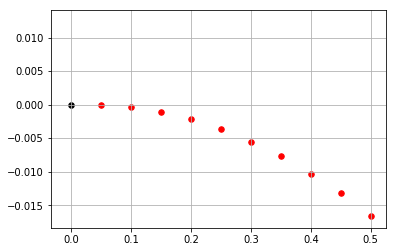

 -- x_train -- 
[[ 4.99998871e-02  1.42924553e-07 -1.58183919e+00]
 [ 9.99984211e-02 -3.67710002e-04 -1.58919919e+00]
 [ 1.49992894e-01 -1.10353885e-03 -1.59655919e+00]
 [ 1.99980596e-01 -2.20730377e-03 -1.60391919e+00]
 [ 2.49958821e-01 -3.67894496e-03 -1.61127919e+00]
 [ 2.99924862e-01 -5.51838271e-03 -1.61863919e+00]
 [ 3.49876010e-01 -7.72551737e-03 -1.62599919e+00]
 [ 3.99809562e-01 -1.03002294e-02 -1.63335919e+00]
 [ 4.49722811e-01 -1.32423793e-02 -1.64071919e+00]
 [ 4.99613055e-01 -1.65518077e-02 -1.64807919e+00]]


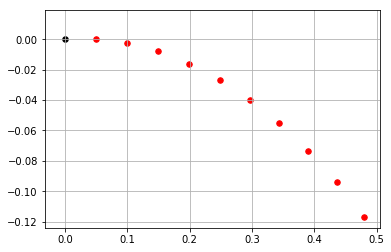

 -- x_train -- 
[[ 4.99940928e-02  1.86136516e-07 -1.65067505e+00]
 [ 9.99173315e-02 -2.66055548e-03 -1.70392505e+00]
 [ 1.49628189e-01 -7.97468193e-03 -1.75717505e+00]
 [ 1.98985741e-01 -1.59271282e-02 -1.81042505e+00]
 [ 2.47850063e-01 -2.64953501e-02 -1.86367505e+00]
 [ 2.96082631e-01 -3.96493877e-02 -1.91692505e+00]
 [ 3.43546711e-01 -5.53519507e-02 -1.97017505e+00]
 [ 3.90107746e-01 -7.35585242e-02 -2.02342505e+00]
 [ 4.35633741e-01 -9.42174943e-02 -2.07667505e+00]
 [ 4.79995636e-01 -1.17270295e-01 -2.12992505e+00]]


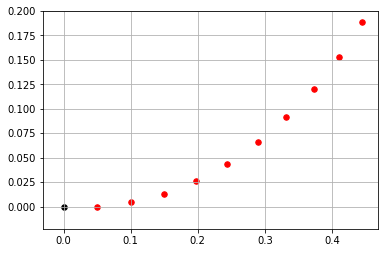

 -- x_train -- 
[[ 4.99833881e-02 -1.21846954e-07 -1.43684389e+00]
 [ 9.97676235e-02  4.45734334e-03 -1.34754389e+00]
 [ 1.48955966e-01  1.33368732e-02 -1.25824389e+00]
 [ 1.97156424e-01  2.65677049e-02 -1.16894389e+00]
 [ 2.43984880e-01  4.40443996e-02 -1.07964389e+00]
 [ 2.89068147e-01  6.56276821e-02 -9.90343889e-01]
 [ 3.32046950e-01  9.11455511e-02 -9.01043889e-01]
 [ 3.72578781e-01  1.20394650e-01 -8.11743889e-01]
 [ 4.10340634e-01  1.53141886e-01 -7.22443889e-01]
 [ 4.45031579e-01  1.89126292e-01 -6.33143889e-01]]


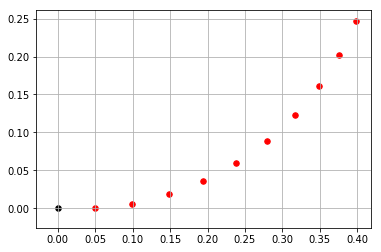

 -- x_train -- 
[[ 4.99681997e-02 -8.46999120e-08 -1.38545463e+00]
 [ 9.95554607e-02  6.15820399e-03 -1.26189463e+00]
 [ 1.48005693e-01  1.83809666e-02 -1.13833463e+00]
 [ 1.94580145e-01  3.64818345e-02 -1.01477463e+00]
 [ 2.38568665e-01  6.01848120e-02 -8.91214632e-01]
 [ 2.79300530e-01  8.91284839e-02 -7.67654632e-01]
 [ 3.16154675e-01  1.22871527e-01 -6.44094632e-01]
 [ 3.48569160e-01  1.60899439e-01 -5.20534632e-01]
 [ 3.76049741e-01  2.02632384e-01 -3.96974632e-01]
 [ 3.98177404e-01  2.47434030e-01 -2.73414632e-01]]


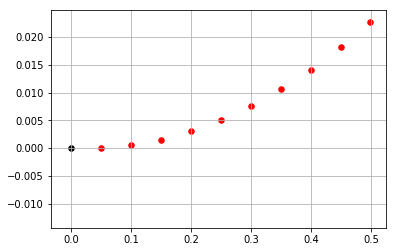

 -- x_train -- 
[[ 4.99997879e-02 -1.73528002e-07 -1.55565786e+00]
 [ 9.99970324e-02  5.04142252e-04 -1.54556786e+00]
 [ 1.49986643e-01  1.51289600e-03 -1.53547786e+00]
 [ 1.99963532e-01  3.02598501e-03 -1.52538786e+00]
 [ 2.49922609e-01  5.04325525e-03 -1.51529786e+00]
 [ 2.99858789e-01  7.56450134e-03 -1.50520786e+00]
 [ 3.49766989e-01  1.05894666e-02 -1.49511786e+00]
 [ 3.99642126e-01  1.41178431e-02 -1.48502786e+00]
 [ 4.49479124e-01  1.81492715e-02 -1.47493786e+00]
 [ 4.99272909e-01  2.26833415e-02 -1.46484786e+00]]


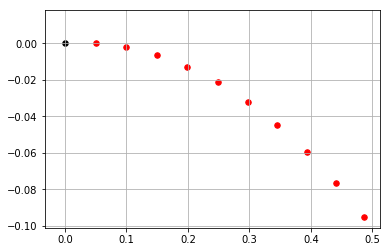

 -- x_train -- 
[[ 4.99961552e-02  2.27093631e-07 -1.63524087e+00]
 [ 9.99461917e-02 -2.14672025e-03 -1.67820087e+00]
 [ 1.49757938e-01 -6.43688031e-03 -1.72116087e+00]
 [ 1.99339477e-01 -1.28623366e-02 -1.76412087e+00]
 [ 2.48599318e-01 -2.14112322e-02 -1.80708087e+00]
 [ 2.97446562e-01 -3.20677923e-02 -1.85004087e+00]
 [ 3.45791073e-01 -4.48123523e-02 -1.89300087e+00]
 [ 3.93543641e-01 -5.96213952e-02 -1.93596087e+00]
 [ 4.40616150e-01 -7.64675940e-02 -1.97892087e+00]
 [ 4.86921738e-01 -9.53198629e-02 -2.02188087e+00]]


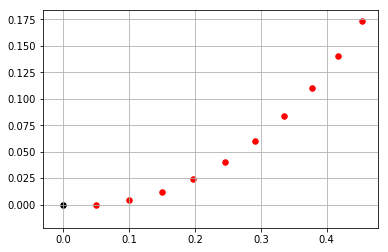

 -- x_train -- 
[[ 4.99862411e-02 -2.17308874e-08 -1.44889089e+00]
 [ 9.98074999e-02  4.05786802e-03 -1.36762089e+00]
 [ 1.49134897e-01  1.21468824e-02 -1.28635089e+00]
 [ 1.97642815e-01  2.42136244e-02 -1.20508089e+00]
 [ 2.45011042e-01  4.01784393e-02 -1.12381089e+00]
 [ 2.90926894e-01  5.99359404e-02 -1.04254089e+00]
 [ 3.35087271e-01  8.33557051e-02 -9.61270892e-01]
 [ 3.77200664e-01  1.10283135e-01 -8.80000892e-01]
 [ 4.16989073e-01  1.40540478e-01 -7.98730892e-01]
 [ 4.54189849e-01  1.73927999e-01 -7.17460892e-01]]


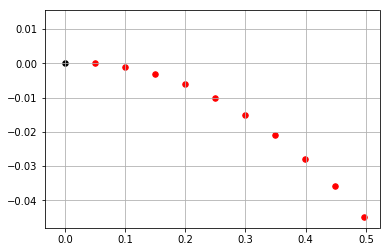

 -- x_train -- 
[[ 4.99991692e-02  1.86851802e-07 -1.60075506e+00]
 [ 9.99883725e-02 -9.98043377e-04 -1.62072506e+00]
 [ 1.49947675e-01 -2.99429261e-03 -1.64069506e+00]
 [ 1.99857154e-01 -5.98776475e-03 -1.66066506e+00]
 [ 2.49696905e-01 -9.97726606e-03 -1.68063506e+00]
 [ 2.99447053e-01 -1.49612056e-02 -1.70060506e+00]
 [ 3.49087759e-01 -2.09375957e-02 -1.72057506e+00]
 [ 3.98599226e-01 -2.79040532e-02 -1.74054506e+00]
 [ 4.47961710e-01 -3.58578000e-02 -1.76051506e+00]
 [ 4.97155526e-01 -4.47956641e-02 -1.78048506e+00]]


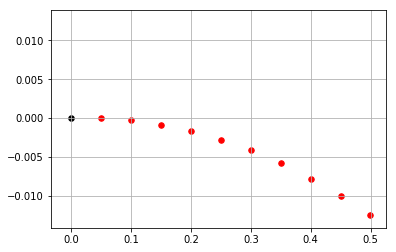

 -- x_train -- 
[[ 4.99999356e-02  5.13331378e-08 -1.57913735e+00]
 [ 9.99990986e-02 -2.77895544e-04 -1.58469735e+00]
 [ 1.49995943e-01 -8.33832039e-04 -1.59025735e+00]
 [ 1.99988925e-01 -1.66774097e-03 -1.59581735e+00]
 [ 2.49976496e-01 -2.77959655e-03 -1.60137735e+00]
 [ 2.99957114e-01 -4.16936441e-03 -1.60693735e+00]
 [ 3.49929231e-01 -5.83700159e-03 -1.61249735e+00]
 [ 3.99891305e-01 -7.78245654e-03 -1.61805735e+00]
 [ 4.49841789e-01 -1.00056691e-02 -1.62361735e+00]
 [ 4.99779140e-01 -1.25065706e-02 -1.62917735e+00]]


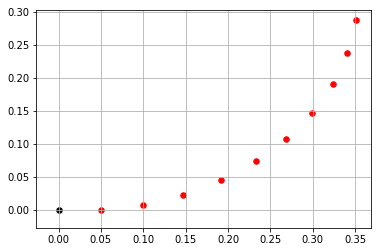

 -- x_train -- 
[[ 4.99518109e-02 -2.19021361e-07 -1.34262694e+00]
 [ 9.93268896e-02  7.56846794e-03 -1.19051694e+00]
 [ 1.46985023e-01  2.25312781e-02 -1.03840694e+00]
 [ 1.91825649e-01  4.45426773e-02 -8.86296942e-01]
 [ 2.32813268e-01  7.30943589e-02 -7.34186942e-01]
 [ 2.69001358e-01  1.07526983e-01 -5.82076942e-01]
 [ 2.99554232e-01  1.47045400e-01 -4.29966942e-01]
 [ 3.23766336e-01  1.90737017e-01 -2.77856942e-01]
 [ 3.41078543e-01  2.37592870e-01 -1.25746942e-01]
 [ 3.51091065e-01  2.86530920e-01  2.63630579e-02]]


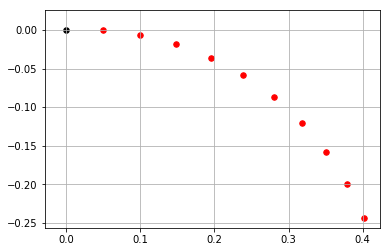

 -- x_train -- 
[[ 4.99695539e-02  1.89150607e-07 -1.75215011e+00]
 [ 9.95743774e-02 -6.02623543e-03 -1.87305011e+00]
 [ 1.48090289e-01 -1.79912939e-02 -1.99395011e+00]
 [ 1.94809005e-01 -3.57203081e-02 -2.11485011e+00]
 [ 2.39048476e-01 -5.89544521e-02 -2.23575011e+00]
 [ 2.80162852e-01 -8.73545301e-02 -2.35665011e+00]
 [ 3.17551902e-01 -1.20505929e-01 -2.47755011e+00]
 [ 3.50669783e-01 -1.57924671e-01 -2.59845011e+00]
 [ 3.79033007e-01 -1.99064480e-01 -2.71935011e+00]
 [ 4.02227499e-01 -2.43324754e-01 -2.84025011e+00]]


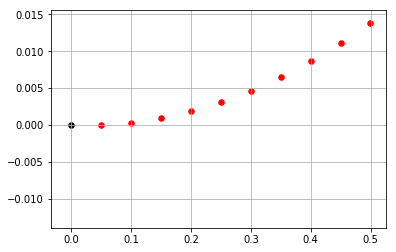

 -- x_train -- 
[[ 4.99999209e-02 -2.02692186e-07 -1.56155227e+00]
 [ 9.99988945e-02  3.07592185e-04 -1.55539227e+00]
 [ 1.49995023e-01  9.23372951e-04 -1.54923227e+00]
 [ 1.99986411e-01  1.84711624e-03 -1.54307227e+00]
 [ 2.49971159e-01  3.07878700e-03 -1.53691227e+00]
 [ 2.99947372e-01  4.61833850e-03 -1.53075227e+00]
 [ 3.49913154e-01  6.46571231e-03 -1.52459227e+00]
 [ 3.99866607e-01  8.62083834e-03 -1.51843227e+00]
 [ 4.49805838e-01  1.10836348e-02 -1.51227227e+00]
 [ 4.99728950e-01  1.38540083e-02 -1.50611227e+00]]


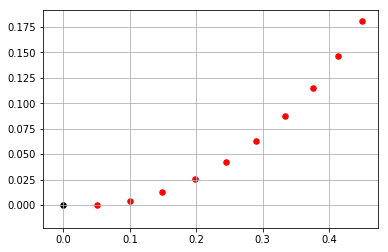

 -- x_train -- 
[[ 4.99849457e-02 -1.39848588e-07 -1.44327853e+00]
 [ 9.97893990e-02  4.24382492e-03 -1.35826853e+00]
 [ 1.49053655e-01  1.27012429e-02 -1.27325853e+00]
 [ 1.97421909e-01  2.53110317e-02 -1.18824853e+00]
 [ 2.44544830e-01  4.19821190e-02 -1.10323853e+00]
 [ 2.90082078e-01  6.25941004e-02 -1.01822853e+00]
 [ 3.33704769e-01  8.69981089e-02 -9.33218529e-01]
 [ 3.75097844e-01  1.15017890e-01 -8.48208529e-01]
 [ 4.13962348e-01  1.46451076e-01 -7.63198529e-01]
 [ 4.50017587e-01  1.81070645e-01 -6.78188529e-01]]


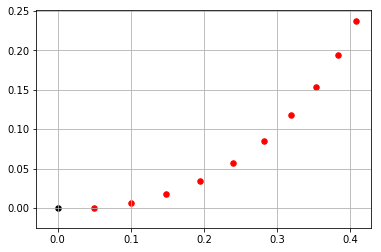

 -- x_train -- 
[[ 4.99713153e-02 -1.54923991e-07 -1.39476823e+00]
 [ 9.95989654e-02  5.85037515e-03 -1.27741823e+00]
 [ 1.48200311e-01  1.74711148e-02 -1.16006823e+00]
 [ 1.95106829e-01  3.47022183e-02 -1.04271823e+00]
 [ 2.39673310e-01  5.73066677e-02 -9.25368227e-01]
 [ 2.81286731e-01  8.49735338e-02 -8.08018227e-01]
 [ 3.19374692e-01  1.17322253e-01 -6.90668227e-01]
 [ 3.53413283e-01  1.53907860e-01 -5.73318227e-01]
 [ 3.82934296e-01  1.94227113e-01 -4.55968227e-01]
 [ 4.07531662e-01  2.37725411e-01 -3.38618227e-01]]


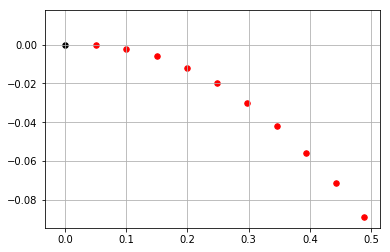

 -- x_train -- 
[[ 4.99966667e-02  6.76727406e-08 -1.63079768e+00]
 [ 9.99533442e-02 -1.99919812e-03 -1.67079768e+00]
 [ 1.49790112e-01 -5.99459899e-03 -1.71079768e+00]
 [ 1.99427243e-01 -1.19797431e-02 -1.75079768e+00]
 [ 2.48785327e-01 -1.99450556e-02 -1.79079768e+00]
 [ 2.97785403e-01 -2.98777936e-02 -1.83079768e+00]
 [ 3.46349080e-01 -4.17620669e-02 -1.87079768e+00]
 [ 3.94398667e-01 -5.55788631e-02 -1.91079768e+00]
 [ 4.41857295e-01 -7.13060783e-02 -1.95079768e+00]
 [ 4.88649040e-01 -8.89185525e-02 -1.99079768e+00]]


In [7]:
# plot data
p = X_train
random.shuffle(p)
if(settings.gpu_index >= 0):
    p = chainer.cuda.to_cpu(X_train)

for num in range(20):
    plt.scatter(0, 0,c="black",edgecolor="black",s=30,marker="o")
    plt.scatter(p[num][:,0], p[num][:,1],c="red",edgecolor="red",s=30,marker="o")
    #plt.xlim([-.2,.2])
    #plt.ylim([-.2,.2])
    plt.grid()
    plt.show()
    print(' -- x_train -- ')
    print(p[num])

In [8]:
# loss
def error_squares(z_oplus,z_true):
    w = xp.array([1., 1., 0.],dtype=xp.float32)
    t = z_true * w
    p = z_oplus * w
    error = F.sqrt(F.sum((t-p)*(t-p)))
    return error

def error_diff_v(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def error_diff_w(y0, y1):
    w = xp.array([0., 0., 1.],dtype=xp.float32)
    v0 = y0 * w
    v1 = y1 * w
    error = F.absolute(F.sum(v1 - v0))
    return error

def calc_oplus(y):
    dst = []
    z = y[0,0]
    dst.append(z)
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y[0,step])
        dst.append(z)
    return dst

def loss_function(y, y_true,disp_loss=0):
    dmesg = ''
    z_true = y_true
    z_oplus = calc_oplus(y)
    # distance - stage cost
    e_distance = error_squares(z_oplus[0],z_true[0])
    for i in range(1,DATA_NUM_WAYPOINTS-1):
        e_distance = e_distance + error_squares(z_oplus[i],z_true[i])
    # distance - terminal cost
    e_distance = e_distance + 10 * error_squares(z_oplus[-1],z_true[-1])
    dmesg = dmesg + 'e_distance: ' + str(e_distance) + '\t'
    '''
    e_diff_v = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_v = e_diff_v + error_diff_v(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dv: ' + str(e_diff_v) + '\t'
    e_diff_w = error_diff_v(y[0,0],y[0,1])
    for i in range(2,DATA_NUM_STEP):
        e_diff_w = e_diff_w + error_diff_w(y[0,i-1],y[0,i])
    dmesg = dmesg + 'e_dw: ' + str(e_diff_w) + '\t'
    '''    
    loss = (1 * e_distance)
    #loss = loss + (1 * e_lim_w)
    #loss = loss + (1 * e_lim_v)
    #loss = loss + (1 * e_diff_v)
    #loss = loss + (1 * e_diff_w)
    if(disp_loss):
        print(dmesg)
    return loss

In [9]:
# training
def train(model,opt,X,epoch=10,clipping=0):
    ep = 0
    AvgLoss = []
    while ep < epoch:
        random.shuffle(X)
        L = .0
        for itr in range(len(X)):
            # forward
            x = X[itr][:,0:2]
            if(DATA_NUM_PREVIOUS_U):
                prev_u = xp.zeros((DATA_NUM_PREVIOUS_U,2),dtype=xp.float32)
                x = xp.vstack((x,prev_u))
            x = xp.ravel(x)
            x = Variable(xp.array([x],dtype=xp.float32))
            y_v, y_w = model(x)
            # clip
            if clipping:
                v_limit = DATA_MAX_V_STEP
                w_limit = DATA_MAX_W_STEP
                v = F.clip(y_v,0.0,v_limit)
                w = F.clip(y_w,-w_limit,w_limit)
            else:
                v = y_v
                w = y_w
            # zero-padding
            pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
            y_pad = F.stack((v,pad,w),axis=2)
            
            # loss
            loss = loss_function(y_pad, X[itr][:])
            
            # update
            model.cleargrads()
            loss.backward()
            opt.update()
            #y_grad = chainer.grad( (e,), (y,) )[0]
            #print(y_grad)
            #x_grad = chainer.grad( (e,), (x,) )[0]
            #print(x_grad)
            L = L + loss.data
        ep = ep + 1
        print('Epoch:',ep,', Average loss:',L / len(X))
        AvgLoss.append(L / len(X))
    return model, AvgLoss

In [10]:
EPOCH = 10
model = Generator(DATA_NUM_WAYPOINTS,DATA_NUM_PREVIOUS_U,DATA_NUM_STEP)
start_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
if settings.gpu_index >= 0:
    cuda.cupy.cuda.Device(settings.gpu_index).use()
    model.to_gpu(settings.gpu_index)
opt = optimizers.Adam()
opt.setup(model)
model,loss_avg = train(model,opt,X_train,epoch=EPOCH,clipping=0)
model,loss_avg_clip = train(model,opt,X_train,epoch=EPOCH,clipping=1)
finish_time = '{0:%Y/%m/%d %H:%M:%S}'.format(datetime.datetime.now())
print('start:',start_time)
print('finish:',finish_time)

Epoch: 1 , Average loss: 1.8699634
Epoch: 2 , Average loss: 0.44026163
Epoch: 3 , Average loss: 0.35277614
Epoch: 4 , Average loss: 0.29072008
Epoch: 5 , Average loss: 0.2755287
Epoch: 6 , Average loss: 0.23285913
Epoch: 7 , Average loss: 0.21865533
Epoch: 8 , Average loss: 0.21727881
Epoch: 9 , Average loss: 0.20670904
Epoch: 10 , Average loss: 0.17921701
Epoch: 1 , Average loss: 0.25074986
Epoch: 2 , Average loss: 0.1801496
Epoch: 3 , Average loss: 0.16910736
Epoch: 4 , Average loss: 0.15409873
Epoch: 5 , Average loss: 0.14950901
Epoch: 6 , Average loss: 0.14653029
Epoch: 7 , Average loss: 0.1394997
Epoch: 8 , Average loss: 0.14979
Epoch: 9 , Average loss: 0.12828715
Epoch: 10 , Average loss: 0.13968955
start: 2019/12/02 05:04:49
finish: 2019/12/02 05:15:08


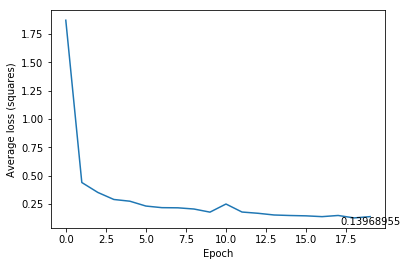

In [11]:
def plot_average_loss(loss_avg):
    fig = plt.figure()
    plt.plot(range(len(loss_avg)),loss_avg)
    plt.xlabel('Epoch')
    plt.ylabel('Average loss (squares)') #*10, lim_v, lim_w, )')
    plt.text(len(loss_avg)-1, loss_avg[-1],str(loss_avg[-1]),ha='center',va='top' )
    return fig
loss_avg.extend(loss_avg_clip)
fig = plot_average_loss(loss_avg)

In [12]:
# log
def gen_filename(header):
    name_date = '{0:%Y%m%d%H%M}'.format(datetime.datetime.now())
    name_epoch = '{}ep'.format(EPOCH)
    name_datasize  = '{}data'.format(DATA_SIZE)
    name_num_step = '{}step'.format(DATA_NUM_STEP)
    name_space = '{}mm'.format(int(DATA_V_STEP * 1000))
    #fn = header + name_space + name_num_step + '_' + name_date + '_'   + name_datasize + name_epoch
    fn = header + name_space + name_num_step + '_' + name_date
    return fn
dirname = gen_filename('w')
os.mkdir(dirname)
print(dirname)

w50mm10step_201912020515


In [13]:
f = open(dirname+'/params.txt','w')
for l in params:
    f.write(l+'\n')
f.close()
serializers.save_npz(dirname +'/'+ dirname+'.model', model)
serializers.save_npz(dirname +'/'+ dirname+'.state', opt)
fig.savefig(dirname + '/' + 'loss.png')

 --- input --- 
[[ 4.99973656e-02  1.68779937e-07 -1.62413970e+00]
 [ 9.99631294e-02 -1.77719419e-03 -1.65969970e+00]
 [ 1.49834116e-01 -5.32984166e-03 -1.69525970e+00]
 [ 1.99547268e-01 -1.06532817e-02 -1.73081970e+00]
 [ 2.49039731e-01 -1.77407835e-02 -1.76637970e+00]
 [ 2.98248927e-01 -2.65833858e-02 -1.80193970e+00]
 [ 3.47112637e-01 -3.71699080e-02 -1.83749970e+00]
 [ 3.95569078e-01 -4.94869650e-02 -1.87305970e+00]
 [ 4.43556983e-01 -6.35189831e-02 -1.90861970e+00]
 [ 4.91015677e-01 -7.92482206e-02 -1.94417970e+00]]
 --- output --- 
[[[ 0.05367399  0.          0.05299762]
  [ 0.03058383  0.         -0.15132837]
  [ 0.07079208  0.          0.0012958 ]
  [ 0.0502561   0.         -0.05733399]
  [ 0.04466716  0.         -0.11257834]
  [ 0.05042291  0.         -0.07460639]
  [ 0.05176752  0.          0.15707964]
  [ 0.04984824  0.         -0.07110341]
  [ 0.05440759  0.         -0.15707964]
  [ 0.04564779  0.         -0.105749  ]]]
 --- error --- 
e_distance: variable(0.15813267)	
loss

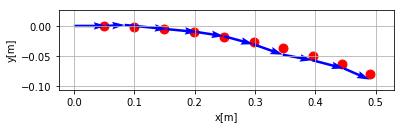

 --- grad --- 
variable([[ 0.5421575  -1.1186061   1.7636199   0.7520184   0.50686926
            2.497237    3.3658059   1.2923597   1.912888    2.731839  ]])
variable([[-5.4072614 -5.0266767 -4.135808  -3.4983854 -2.9239745
           -2.2403736  0.        -1.0170865  0.         0.       ]])


In [14]:
rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
d = data.rotate_path(d,rand_rad*0.5)
if DATA_RANGE_TRANSLATE != 0:
    rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
    d = data.translate_path(d,rand_trans_x,0.0)
if DATA_RANGE_ROTATE != 0:
    rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
    d = data.rotate_path(d,rand_rotate)
x_test = d
'''
x_test = xp.array(
    [[ 0.02293546, -0.04092823,0],
     [ 0.05309581, -0.05415406,0],
     [ 0.08393338, -0.06682136,0],
     [ 0.11579048, -0.07606434,0],
     [ 0.14647007, -0.08932315,0],
     [ 0.17848524, -0.09797464,0],
     [ 0.21082233, -0.10660645,0],
     [ 0.24306089, -0.11521195,0],
     [ 0.27361556, -0.12854306,0],
     [ 0.3055584,  -0.13706963,0]]
    , dtype = xp.float32)
'''

x = x_test[:,0:2]
if DATA_NUM_PREVIOUS_U:
    prev_u = xp.array([.0,.0],dtype=xp.float32)
    x = xp.vstack((x,prev_u))
x = xp.ravel(x)
x = xp.array([x],dtype=xp.float32)
y_v,y_w = model(x)
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print(' --- output --- ')
print(y_pad.data)
# loss
print(' --- error --- ')
loss = loss_function(y_pad, x_test, disp_loss=1)
print('loss:',loss)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
print(' --- grad --- ')
v_grad = chainer.grad( (loss,), (y_v,) )[0]
print(v_grad)
w_grad = chainer.grad( (loss,), (y_w,) )[0]
print(w_grad)
#x_grad = chainer.grad( (loss,), (x,) )[0]
#print(x_grad)

 --- input --- 
[[ 4.99988020e-02 -1.15004229e-07 -1.53482403e+00]
 [ 9.99832318e-02  1.19862639e-03 -1.51084403e+00]
 [ 1.49924548e-01  3.59553489e-03 -1.48686403e+00]
 [ 1.99794033e-01  7.18923225e-03 -1.46288403e+00]
 [ 2.49563011e-01  1.19776520e-02 -1.43890403e+00]
 [ 2.99202866e-01  1.79580409e-02 -1.41492403e+00]
 [ 3.48685053e-01  2.51269599e-02 -1.39094403e+00]
 [ 3.97981119e-01  3.34802870e-02 -1.36696403e+00]
 [ 4.47062718e-01  4.30132187e-02 -1.34298403e+00]
 [ 4.95901629e-01  5.37202737e-02 -1.31900403e+00]]
 --- output --- 
[[[ 0.05212944  0.          0.06736977]
  [ 0.04669542  0.         -0.058383  ]
  [ 0.05347833  0.          0.04827232]
  [ 0.04917698  0.          0.02091671]
  [ 0.04690515  0.         -0.00990373]
  [ 0.04841053  0.          0.00452825]
  [ 0.05388081  0.          0.15707964]
  [ 0.04757032  0.          0.01320183]
  [ 0.0528101   0.         -0.15707964]
  [ 0.04783001  0.         -0.12251647]]]
 --- error --- 
loss: variable(0.00213064)
loss: varia

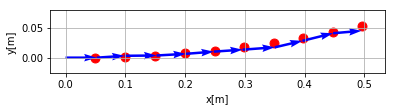

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99958206e-02  8.49090247e-08 -1.63798303e+00]
 [ 9.99415041e-02 -2.23839442e-03 -1.68277303e+00]
 [ 1.49736869e-01 -6.71094802e-03 -1.72756303e+00]
 [ 1.99282035e-01 -1.34086048e-02 -1.77235303e+00]
 [ 2.48477624e-01 -2.23179306e-02 -1.81714303e+00]
 [ 2.97224959e-01 -3.34210549e-02 -1.86193303e+00]
 [ 3.45426263e-01 -4.66957070e-02 -1.90672303e+00]
 [ 3.92984853e-01 -6.21152606e-02 -1.95151303e+00]
 [ 4.39805335e-01 -7.96487869e-02 -1.99630303e+00]
 [ 4.85793796e-01 -9.92611170e-02 -2.04109303e+00]]
 --- output --- 
[[[ 0.05319298  0.          0.05151322]
  [ 0.02718541  0.         -0.15707964]
  [ 0.07428883  0.         -0.00544709]
  [ 0.0509587   0.         -0.06894551]
  [ 0.04407464  0.         -0.1279994 ]
  [ 0.05079183  0.         -0.08686572]
  [ 0.05022757  0.          0.15707964]
  [ 0.0505665   0.         -0.08426619]
  [ 0.05521166  0.         -0.15707964]

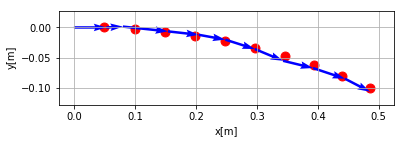

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99932789e-02 -1.28189885e-07 -1.48559376e+00]
 [ 9.99059417e-02  2.83783544e-03 -1.42879376e+00]
 [ 1.49577001e-01  8.50473738e-03 -1.37199376e+00]
 [ 1.98846250e-01  1.69822998e-02 -1.31519376e+00]
 [ 2.47554776e-01  2.82431793e-02 -1.25839376e+00]
 [ 2.95545477e-01  4.22510555e-02 -1.20159376e+00]
 [ 3.42663564e-01  5.89607477e-02 -1.14479376e+00]
 [ 3.88757064e-01  7.83183609e-02 -1.08799376e+00]
 [ 4.33677308e-01  1.00261460e-01 -1.03119376e+00]
 [ 4.77279413e-01  1.24719269e-01 -9.74393763e-01]]
 --- output --- 
[[[ 0.05047751  0.          0.08251071]
  [ 0.05119613  0.         -0.00270135]
  [ 0.04883099  0.          0.0765122 ]
  [ 0.04873527  0.          0.06187383]
  [ 0.04778268  0.          0.04253428]
  [ 0.0479678   0.          0.0473301 ]
  [ 0.05287857  0.          0.15707964]
  [ 0.04727488  0.          0.05762865]
  [ 0.05276268  0.         -0.15707964]

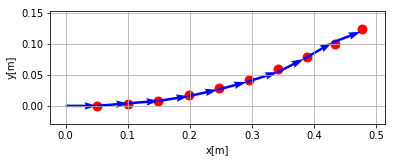

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99996027e-02 -2.76465923e-09 -1.55008127e+00]
 [ 9.99944376e-02  6.90467036e-04 -1.53627127e+00]
 [ 1.49974970e-01  2.07127772e-03 -1.52246127e+00]
 [ 1.99931668e-01  4.14216595e-03 -1.50865127e+00]
 [ 2.49855005e-01  6.90273678e-03 -1.49484127e+00]
 [ 2.99735458e-01  1.03524637e-02 -1.48103127e+00]
 [ 3.49563516e-01  1.44906889e-02 -1.46722127e+00]
 [ 3.99329676e-01  1.93166231e-02 -1.45341127e+00]
 [ 4.49024446e-01  2.48293459e-02 -1.43960127e+00]
 [ 4.98638348e-01  3.10278059e-02 -1.42579127e+00]]
 --- output --- 
[[[ 0.05294891  0.          0.06432878]
  [ 0.04469858  0.         -0.0753428 ]
  [ 0.05572836  0.          0.03995629]
  [ 0.04897914  0.          0.00741876]
  [ 0.04669823  0.         -0.02747197]
  [ 0.04869579  0.         -0.00878013]
  [ 0.05445818  0.          0.15707964]
  [ 0.04766746  0.         -0.00085171]
  [ 0.05266843  0.         -0.15707964]

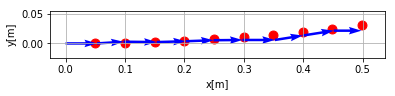

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99998575e-02  2.38871167e-07 -1.58320610e+00]
 [ 9.99980072e-02 -4.13016374e-04 -1.59147610e+00]
 [ 1.49991030e-01 -1.23973747e-03 -1.59974610e+00]
 [ 1.99975505e-01 -2.47986788e-03 -1.60801610e+00]
 [ 2.49948016e-01 -4.13332279e-03 -1.61628610e+00]
 [ 2.99905144e-01 -6.19998910e-03 -1.62455610e+00]
 [ 3.49843473e-01 -8.67972549e-03 -1.63282610e+00]
 [ 3.99759587e-01 -1.15723623e-02 -1.64109610e+00]
 [ 4.49650071e-01 -1.48777018e-02 -1.64936610e+00]
 [ 4.99511515e-01 -1.85955179e-02 -1.65763610e+00]]
 --- output --- 
[[[ 0.05395135  0.          0.0585525 ]
  [ 0.03926897  0.         -0.11081143]
  [ 0.06165628  0.          0.02222439]
  [ 0.04905913  0.         -0.02188695]
  [ 0.04601515  0.         -0.06581134]
  [ 0.04940648  0.         -0.03810944]
  [ 0.05440072  0.          0.15707964]
  [ 0.0482924   0.         -0.03203357]
  [ 0.05292887  0.         -0.15707964]

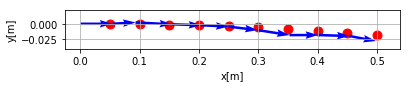

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99956491e-02 -1.93387946e-08 -1.50224594e+00]
 [ 9.99391004e-02  2.28396729e-03 -1.45654594e+00]
 [ 1.49726066e-01  6.84719064e-03 -1.41084594e+00]
 [ 1.99252584e-01  1.36801221e-02 -1.36514594e+00]
 [ 2.48415237e-01  2.27684937e-02 -1.31944594e+00]
 [ 2.97111366e-01  3.40933277e-02 -1.27374594e+00]
 [ 3.45239290e-01  4.76309765e-02 -1.22804594e+00]
 [ 3.92698509e-01  6.33531716e-02 -1.18234594e+00]
 [ 4.39389924e-01  8.12270833e-02 -1.13664594e+00]
 [ 4.85216036e-01  1.01215388e-01 -1.09094594e+00]]
 --- output --- 
[[[ 0.04987074  0.          0.07497511]
  [ 0.04989636  0.         -0.0213019 ]
  [ 0.04978602  0.          0.06627338]
  [ 0.04984544  0.          0.04922666]
  [ 0.04720857  0.          0.02672802]
  [ 0.04792757  0.          0.032393  ]
  [ 0.05172755  0.          0.15707964]
  [ 0.04768799  0.          0.04234165]
  [ 0.05348209  0.         -0.15707964]

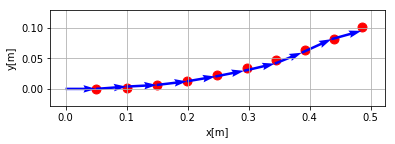

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99989926e-02 -2.60916319e-08 -1.53781080e+00]
 [ 9.99858975e-02  1.09933706e-03 -1.51582080e+00]
 [ 1.49936544e-01  3.29755787e-03 -1.49383080e+00]
 [ 1.99826779e-01  6.59357341e-03 -1.47184080e+00]
 [ 2.49632478e-01  1.09857899e-02 -1.44985080e+00]
 [ 2.99329559e-01  1.64720836e-02 -1.42786080e+00]
 [ 3.48893991e-01  2.30498016e-02 -1.40587080e+00]
 [ 3.98301807e-01  3.07157633e-02 -1.38388080e+00]
 [ 4.47529117e-01  3.94662619e-02 -1.36189080e+00]
 [ 4.96552117e-01  4.92970662e-02 -1.33990080e+00]]
 --- output --- 
[[[ 0.05230714  0.          0.06675636]
  [ 0.04633016  0.         -0.06172669]
  [ 0.05389384  0.          0.04664045]
  [ 0.04912759  0.          0.01828086]
  [ 0.04686959  0.         -0.0133301 ]
  [ 0.04846408  0.          0.00193818]
  [ 0.05402299  0.          0.15707964]
  [ 0.04757995  0.          0.01047223]
  [ 0.05276996  0.         -0.15707964]

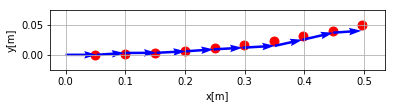

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99981685e-02  1.49786404e-07 -1.61527432e+00]
 [ 9.99743658e-02 -1.48192899e-03 -1.64492432e+00]
 [ 1.49884660e-01 -4.44493350e-03 -1.67457432e+00]
 [ 1.99685177e-01 -8.88625908e-03 -1.70422432e+00]
 [ 2.49332139e-01 -1.48020016e-02 -1.73387432e+00]
 [ 2.98781904e-01 -2.21869606e-02 -1.76352432e+00]
 [ 3.47991002e-01 -3.10346445e-02 -1.79317432e+00]
 [ 3.96916176e-01 -4.13372756e-02 -1.82282432e+00]
 [ 4.45514418e-01 -5.30857972e-02 -1.85247432e+00]
 [ 4.93743006e-01 -6.62698818e-02 -1.88212432e+00]]
 --- output --- 
[[[ 0.05387868  0.          0.054052  ]
  [ 0.03264116  0.         -0.14291419]
  [ 0.06865646  0.          0.00571035]
  [ 0.0498869   0.         -0.04978218]
  [ 0.0450095   0.         -0.10257661]
  [ 0.0501924   0.         -0.06672046]
  [ 0.05258113  0.          0.15707964]
  [ 0.04943869  0.         -0.06264432]
  [ 0.05397453  0.         -0.15707964]

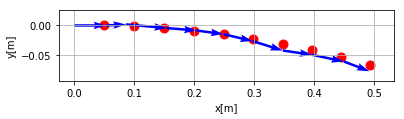

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99994600e-02  2.14592621e-07 -1.59495062e+00]
 [ 9.99924434e-02 -8.04527372e-04 -1.61105062e+00]
 [ 1.49965992e-01 -2.41401730e-03 -1.62715062e+00]
 [ 1.99907152e-01 -4.82783801e-03 -1.64325062e+00]
 [ 2.49802979e-01 -8.04536382e-03 -1.65935062e+00]
 [ 2.99640539e-01 -1.20657607e-02 -1.67545062e+00]
 [ 3.49406914e-01 -1.68879867e-02 -1.69155062e+00]
 [ 3.99089206e-01 -2.25107916e-02 -1.70765062e+00]
 [ 4.48674535e-01 -2.89327182e-02 -1.72375062e+00]
 [ 4.98150049e-01 -3.61521018e-02 -1.73985062e+00]]
 --- output --- 
[[[ 0.05404543  0.          0.05677918]
  [ 0.03699353  0.         -0.12285344]
  [ 0.06408303  0.          0.01608681]
  [ 0.0492721   0.         -0.03218846]
  [ 0.04568822  0.         -0.07935643]
  [ 0.0496846   0.         -0.04858707]
  [ 0.05393802  0.          0.15707964]
  [ 0.04865074  0.         -0.04322626]
  [ 0.05321844  0.         -0.15707964]

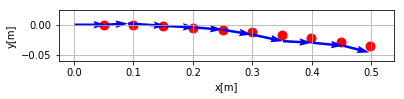

 ---------------------------------------------------------------------------------------------- 
 --- input --- 
[[ 4.99940706e-02 -1.01022255e-07 -1.49076931e+00]
 [ 9.99170163e-02  2.66571671e-03 -1.43741931e+00]
 [ 1.49626779e-01  7.98986749e-03 -1.38406931e+00]
 [ 1.98981907e-01  1.59572012e-02 -1.33071931e+00]
 [ 2.47841959e-01  2.65450464e-02 -1.27736931e+00]
 [ 2.96067900e-01  3.97232749e-02 -1.22401931e+00]
 [ 3.43522501e-01  5.54543873e-02 -1.17066931e+00]
 [ 3.90070729e-01  7.36936202e-02 -1.11731931e+00]
 [ 4.35580127e-01  9.43890728e-02 -1.06396931e+00]
 [ 4.79921197e-01  1.17481855e-01 -1.01061931e+00]]
 --- output --- 
[[[ 0.05031927  0.          0.08014904]
  [ 0.05083427  0.         -0.0084981 ]
  [ 0.04908502  0.          0.07333686]
  [ 0.0490662   0.          0.05797169]
  [ 0.04761025  0.          0.03766205]
  [ 0.04795129  0.          0.0427281 ]
  [ 0.05256869  0.          0.15707964]
  [ 0.04738769  0.          0.05293303]
  [ 0.05296732  0.         -0.15707964]

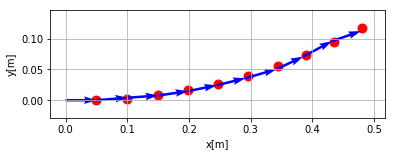

 ---------------------------------------------------------------------------------------------- 


In [15]:
for i in range(10):
    rand_rad = xp.random.rand()*(2*DATA_W_STEP)-DATA_W_STEP # -36 ~ 36 m/step
    d = data.generate_arc_path(DATA_NUM_STEP,rand_rad,DATA_V_STEP)
    d = data.rotate_path(d,rand_rad*0.5)
    if DATA_RANGE_TRANSLATE != 0:
        rand_trans_x = xp.random.rand() * DATA_RANGE_TRANSLATE
        d = data.translate_path(d,rand_trans_x,0.0)
    if DATA_RANGE_ROTATE != 0:
        rand_rotate = xp.random.rand()*(DATA_RANGE_ROTATE*2)-DATA_RANGE_ROTATE
        d = data.rotate_path(d,rand_rotate)
    
    x_test = d
    x = x_test[:,0:2]
    if DATA_NUM_PREVIOUS_U:
        prev_u = xp.array([.0,.0],dtype=xp.float32)
        x = xp.vstack((x,prev_u))
    x = xp.ravel(x)
    x = Variable(xp.array([x],dtype=xp.float32))
    y_v,y_w = model(x)
    # clip
    v_limit = DATA_MAX_V_STEP
    w_limit = DATA_MAX_W_STEP
    v = F.clip(y_v,0.0,v_limit)
    w = F.clip(y_w,-w_limit,w_limit)
    # zero-padding
    pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
    y_pad = F.stack((v,pad,w),axis=2)
    print(' --- input --- ')
    print(x_test)
    print(' --- output --- ')
    print(y_pad.data)
    # loss
    z_true = x_test
    z = y_pad[0,0]
    e = error_squares(z,z_true[0])
    print(' --- error --- ')
    print('loss:',e)
    Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
    for step in range(1,DATA_NUM_STEP):
        z = oplus(z,y_pad[0,step])
        e = error_squares(z,z_true[step])
        print('loss:',e)
        Z = xp.vstack((Z,z.data))
    #print(' --- trajectory --- ')
    #print(Z)
    #print(z_true.shape)
    fig = plot_path(Z,z_true)
    #fig.savefig(dirname + '/test' + str(i) + '.png')
    print(' ---------------------------------------------------------------------------------------------- ')

In [16]:
'''
x = xp.array([ 0.04362432, -0.01988486,  0.0504621,  -0.06733729,  0.01422674,
           -0.09872974, -0.03176716, -0.08520015, -0.04523301, -0.03918755,
           -0.01379037, -0.00299572,  0.03365254, -0.00989925,  0.05347693,
           -0.05355108,  0.02745634, -0.09381791, -0.02048601, -0.09367861],dtype=xp.float32)
x_test = xp.reshape(x,(10,2))
y_v =xp.array([[ 0.05098518,  0.05301605,  0.04617335,  0.05058391,  0.04857601,  0.04970181,
   0.05061447,  0.0512807,   0.05293243,  0.04999607]],dtype=xp.float32)
y_w =xp.array([[-0.0903318,  -0.09855502, -0.08380567, -0.08425293, -0.23067333, -0.0578969,
  -0.1067691,  -0.14234726, -0.06991683, -0.10047609]],dtype=xp.float32)
 
# clip
v_limit = DATA_MAX_V_STEP
w_limit = DATA_MAX_W_STEP
v = F.clip(y_v,0.0,v_limit)
w = F.clip(y_w,-w_limit,w_limit)
# zero-padding
pad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))
y_pad = F.stack((v,pad,w),axis=2)
print(' --- input --- ')
print(x_test)
print('v')
print(v)
print('w')
print(w)
print(' --- output --- ')
print(y_pad.data)
z_true = x_test
z = y_pad[0,0]
Z = xp.array([([0,0,0]),(z.data)],dtype='float32')
for step in range(1,DATA_NUM_STEP):
    z = oplus(z,y_pad[0,step])
    Z = xp.vstack((Z,z.data))
#print(' --- trajectory --- ')
#print(Z)
#print(z_true.shape)
fig = plot_path(Z,z_true)
'''

"\nx = xp.array([ 0.04362432, -0.01988486,  0.0504621,  -0.06733729,  0.01422674,\n           -0.09872974, -0.03176716, -0.08520015, -0.04523301, -0.03918755,\n           -0.01379037, -0.00299572,  0.03365254, -0.00989925,  0.05347693,\n           -0.05355108,  0.02745634, -0.09381791, -0.02048601, -0.09367861],dtype=xp.float32)\nx_test = xp.reshape(x,(10,2))\ny_v =xp.array([[ 0.05098518,  0.05301605,  0.04617335,  0.05058391,  0.04857601,  0.04970181,\n   0.05061447,  0.0512807,   0.05293243,  0.04999607]],dtype=xp.float32)\ny_w =xp.array([[-0.0903318,  -0.09855502, -0.08380567, -0.08425293, -0.23067333, -0.0578969,\n  -0.1067691,  -0.14234726, -0.06991683, -0.10047609]],dtype=xp.float32)\n \n# clip\nv_limit = DATA_MAX_V_STEP\nw_limit = DATA_MAX_W_STEP\nv = F.clip(y_v,0.0,v_limit)\nw = F.clip(y_w,-w_limit,w_limit)\n# zero-padding\npad = Variable(xp.zeros((1,DATA_NUM_STEP),dtype=xp.float32))\ny_pad = F.stack((v,pad,w),axis=2)\nprint(' --- input --- ')\nprint(x_test)\nprint('v')\nprint(